## Parameters

In [35]:
# ------- PARAMETERS ------- #

RUNS = [155]  # run indexes

root = '/pnfs/pic.es/data/cta/LST/LST3/Data/ZFITS/' # path to all folders with the .zfits files

# frequency used in the runs (in Hertzs)
freq = 100

# -------------------------- #

# other parameters

bins1, bins2 = 30, 64         # number of time bins we divide all the data

delta_stdv = 100               # the difference to the total mean pedestal to count an event as a flash

subrun = 0                    # subrun we analyse

graphs_format = 'pdf'         # file format of images
dir_files     = 'csv_files/'  # path (relative or absolute) to the .csv files that will be created
dir_graphs    = 'graphs/'

### Packages and some definitions

In [14]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy             as np

from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates   import EngineeringCameraFrame
from traitlets.config      import Config
from ctapipe.io            import EventSource

import auxiliar as aux
aux.parameters()

# extracting the number of LST
LST_camera = aux.find_LST_num(root) 

# creating the folder if dont exist
aux.create_folder(dir_files)        
aux.create_folder(dir_graphs)

# getting geometry of the camera
date, subruns = aux.search(root,RUNS[0])    
config  = Config({'LSTEventSource': {'default_trigger_type': 'ucts','allowed_tels': [1],
                                    'min_flatfield_adc': 3000,'min_flatfield_pixel_fraction': 0.8,},}) 

path    = root + date + '/'
path    = path + 'LST-' + LST_camera + '.1.Run' + str(RUNS[0]).zfill(5) + '.' + str(0).zfill(4) + '.fits.fz'
source  = EventSource(input_url=path, config=config, max_events=1)
camgeom = source.subarray.tel[1].camera.geometry
LSTgeom = camgeom.transform_to(EngineeringCameraFrame())

In [4]:
RUN = 155

print('Analysisng Run ' + str(RUN) + '- Subrun ' + str(subrun) + '\n')

# ----- data extraction ----- #
# opening both divided files for each subrun
path1 = dir_files + 'data_Run' + str(RUN) + '_Subrun' + str(subrun) + '_1.csv'
path2 = dir_files + 'data_Run' + str(RUN) + '_Subrun' + str(subrun) + '_2.csv'

p_1, s_1, t_1 = aux.readPedestalCSV(path1)
p_2, s_2, t_2 = aux.readPedestalCSV(path2)

pedestal = [np.concatenate([_p_1_, _p_2_]) for _p_1_, _p_2_ in zip(p_1, p_2)]
stdv     = [np.concatenate([_s_1_, _s_2_]) for _s_1_, _s_2_ in zip(s_1, s_2)]

t_2  = np.array(t_2) + np.array(t_1)[-1]
time =  np.concatenate([t_1, t_2])    

Analysisng Run 155- Subrun 0

Reading CSV...
Finished

Reading CSV...
Finished



In [15]:
# ---- calculus of data means ---- #

#transposing the data to take events or pixels information
pedestal_tr       = np.transpose(pedestal)
stdv_tr           = np.transpose(stdv)

# mean and stdv of each event (for all pixels)
pedestalMeanEv    = [np.mean(pedestal_tr[px]) for px in range(len(pedestal_tr))]
stdvMeanEv        = [np.mean(stdv_tr[px])     for px in range(len(stdv_tr))]

# mean and stdv of each pixel (for all events)
pedestalMeanPx    = [np.mean(pedestal[ev]) for ev in range(len(pedestal))]
stdvMeanPx        = [np.mean(stdv[ev])     for ev in range(len(stdv))]

# mean of ALL pedestals and stdv of all pixels
pedestalMeanTotal = np.mean(pedestalMeanPx)
stdvMeanTotal     = np.mean(stdvMeanPx)

# arrays for each pixel, saving the dt, the pedestal and the rms
dt                = [[] for px in range(1855)]
pedestalTotal     = [[] for px in range(1855)]
stdvTotal         = [[] for px in range(1855)]

# -------------------------------- #

In [36]:


# -------- finding flashes ------- #
# first flash finding
firstTimeIndex = None
for ev in range(len(time)):

    if abs(stdvMeanEv[ev] - stdvMeanTotal) > delta_stdv and ev >= 2:
        timestart = time[ev]

        for px in range(1855):
            dt[px].append(0)
            pedestalTotal[px].append(pedestal[px][ev] / pedestalMeanPx[px])
            stdvTotal[px].append(stdv[px][ev] / stdvMeanPx[px])

        firstTimeIndex = ev - 1
        break

if firstTimeIndex == None:
    print(f'Not flashes found')





In [38]:
# all the following flashes
for ev in range(len(time))[firstTimeIndex:]:

    if ev % 1700 == 0 or ev == 0:
        print('Finding flashes - ' + str(int(100 * ev / len(time))) + '%...')

    # detecting the flash and setting this time as the initial
    if abs(stdvMeanEv[ev] - stdvMeanTotal) > delta_stdv:
        timestart = time[ev]

        for px in range(1855):
            dt[px].append(0)
            pedestalTotal[px].append(pedestal[px][ev] / pedestalMeanPx[px])
            stdvTotal[px].append(stdv[px][ev] / stdvMeanPx[px])

    # all the other events without flash
    else:
        for px in range(1855):   
            dt[px].append(time[ev] - timestart)
            pedestalTotal[px].append(pedestal[px][ev] / pedestalMeanPx[px])
            stdvTotal[px].append(stdv[px][ev] / stdvMeanPx[px])

print('Finding flashes - 100% \n')
# -------------------------------- #

Finding flashes - 14%...
Finding flashes - 29%...
Finding flashes - 44%...
Finding flashes - 59%...
Finding flashes - 74%...
Finding flashes - 89%...
Finding flashes - 100% 



Extracting first 5% points...
Finished

Binning - 0%...
Binning - 22%...
Binning - 45%...
Binning - 68%...
Binning - 91%...
Binning - 100% 

Getting mean values...
Finished 

Binning - 0%...
Binning - 22%...
Binning - 45%...
Binning - 68%...
Binning - 91%...
Binning - 100% 

Getting mean values...
Finished 

Binning - 0%...
Binning - 96%...
Binning - 100% 

Getting mean values...
Finished 

Binning - 0%...
Binning - 96%...
Binning - 100% 

Getting mean values...
Finished 

Binning - 0%...
Binning - 96%...
Binning - 100% 

Getting mean values...
Finished 



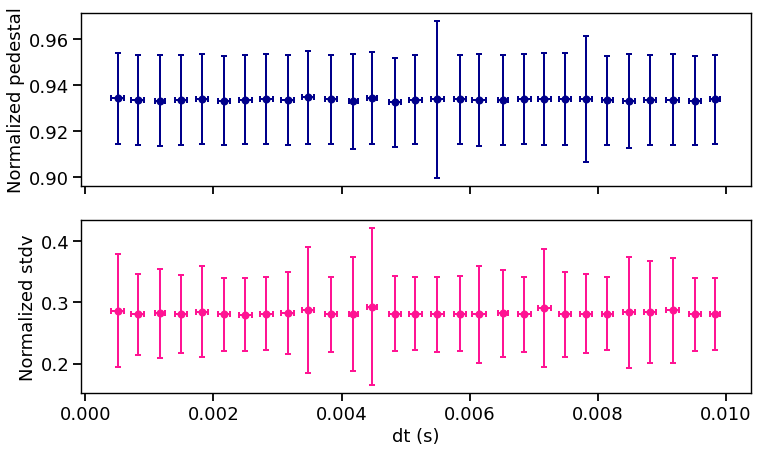

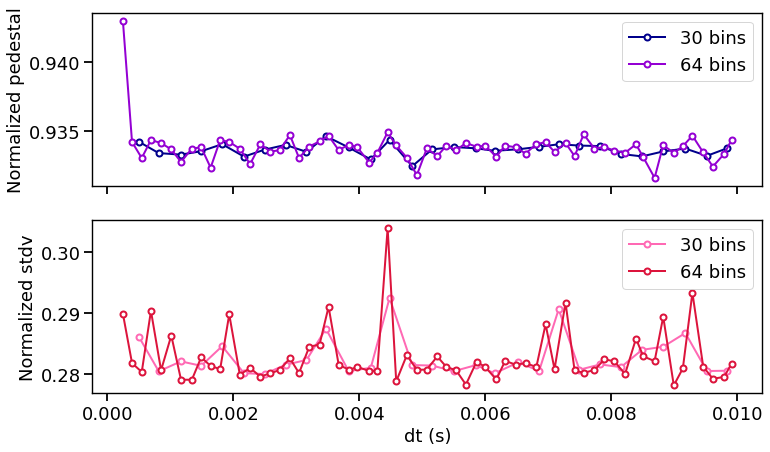

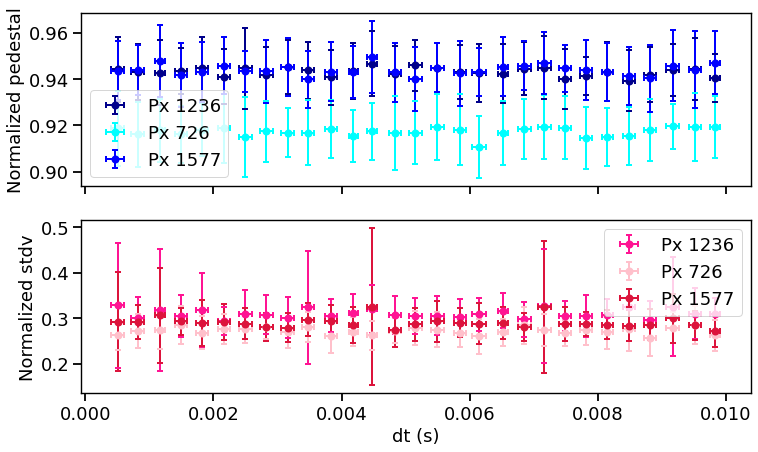

In [ ]:
# ----- finding 5% of the dt ----- #
# first 5% of the dt finding
dtFirst       = []
pedestalFirst = []
stdvFirst     = []

print('Extracting first 5% points...')
for ev in range(len(dt[0])):

    for px in range(1855):

        if dt[px][ev] < 0.05 / freq and dt[px][ev] > 0:

            dtFirst.append(dt[px][ev])
            pedestalFirst.append(pedestal[px][ev])
            stdvFirst.append(stdv[px][ev])
print('Finished\n')
# -------------------------------- #


# extracting the data for different binnings
pedestal1, stdv1, dt1 = aux.binning(bins1, freq, dt, time, pedestalTotal, stdvTotal)
pedestal2, stdv2, dt2 = aux.binning(bins2, freq, dt, time, pedestalTotal, stdvTotal)

# and for 3 different pixels
px1, px2, px3 = int(np.random.rand() * 1855), int(np.random.rand() * 1855), int(np.random.rand() * 1855)
pedestal3, stdv3, dt3 = aux.binningPX(bins1, px1, freq, dt, time, pedestalTotal, stdvTotal)
pedestal4, stdv4, dt4 = aux.binningPX(bins1, px2, freq, dt, time, pedestalTotal, stdvTotal)
pedestal5, stdv5, dt5 = aux.binningPX(bins1, px3, freq, dt, time, pedestalTotal, stdvTotal)


# ----- total pedestal and stdv ----- #

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

# ax1 pedestal values -------------
c1 = 'darkblue'
ax1.errorbar(dt1[0][1:], pedestal1[0][1:], pedestal1[1][1:], dt1[1][1:], 'o', capsize=3, color=c1)
ax1.set_ylabel('Normalized pedestal')

# ax2 stdv values -----------------
ax2.errorbar(dt1[0][1:], stdv1[0][1:], stdv1[1][1:], dt1[1][1:], 'o', capsize=3, color='deeppink')
ax2.set_ylabel('Normalized stdv')
ax2.set_xlabel('dt (s)')

savename = dir_graphs + 'pedestalRecovery_error_Run' + str(RUN) + '_subrun' + str(subrun) 
plt.savefig(savename + '.' + graphs_format, bbox_inches='tight', format=graphs_format)
plt.show()
# ----------------------------------- #


# ----------------------------------- #
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

# ax1 pedestal values -------------
l1, c1 = str(bins1) + ' bins', 'darkblue'
l2, c2 = str(bins2) + ' bins', 'darkviolet'
ax1.plot(dt1[0][1:], pedestal1[0][1:], '-', marker='o', markerfacecolor='w', label=l1, color=c1) 
ax1.plot(dt2[0][1:], pedestal2[0][1:], '-', marker='o', markerfacecolor='w', label=l2, color=c2)
ax1.set_ylabel('Normalized pedestal')
ax1.legend()

# ax2 stdv values -----------------
l1 = str(bins1) + ' bins'
l2 = str(bins2) + ' bins'
ax2.plot(dt1[0][1:], stdv1[0][1:], '-', marker='o', markerfacecolor='w', label=l1, color='hotpink')
ax2.plot(dt2[0][1:], stdv2[0][1:], '-', marker='o', markerfacecolor='w', label=l2, color='crimson')
ax2.set_ylabel('Normalized stdv') 
ax2.set_xlabel('dt (s)')
ax2.legend()

savename = dir_graphs + 'pedestalRecovery_Run' + str(RUN) + '_subrun' + str(subrun)
plt.savefig(savename + '.' + graphs_format, bbox_inches='tight', format=graphs_format)  
plt.show()
# ----------------------------------- #

# ----------------------------------- #
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

# ax1 pedestal values -------------
c1, l1 = 'darkblue', 'Px ' + str(px1)
c2, l2 = 'cyan'    , 'Px ' + str(px2)
c3, l3 = 'b'       , 'Px ' + str(px3)
ax1.errorbar(dt3[0][1:], pedestal3[0][1:], pedestal3[1][1:], dt3[1][1:], 'o',capsize=3,color=c1,label=l1)
ax1.errorbar(dt4[0][1:], pedestal4[0][1:], pedestal4[1][1:], dt4[1][1:], 'o',capsize=3,color=c2,label=l2)
ax1.errorbar(dt5[0][1:], pedestal5[0][1:], pedestal5[1][1:], dt5[1][1:], 'o',capsize=3,color=c3,label=l3)
ax1.set_ylabel('Normalized pedestal')
ax1.legend()

# ax2 stdv values -----------------
c1, l1 = 'deeppink', 'Px ' + str(px1)
c2, l2 = 'pink'    , 'Px ' + str(px2)
c3, l3 = 'crimson' , 'Px ' + str(px3)
ax2.errorbar(dt3[0][1:], stdv3[0][1:], stdv3[1][1:], dt3[1][1:], 'o', capsize=3, color=c1, label=l1)
ax2.errorbar(dt4[0][1:], stdv4[0][1:], stdv4[1][1:], dt4[1][1:], 'o', capsize=3, color=c2, label=l2)
ax2.errorbar(dt5[0][1:], stdv5[0][1:], stdv5[1][1:], dt5[1][1:], 'o', capsize=3, color=c3, label=l3)
ax2.set_ylabel('Normalized stdv')
ax2.set_xlabel('dt (s)')
ax2.legend()

savename = dir_graphs + 'pixels_Run' + str(RUN) + '_subrun' + str(subrun)
plt.savefig(savename + '.' + graphs_format, bbox_inches='tight', format=graphs_format)
plt.show()
# ----------------------------------- #

# ------ camera plot ------ #

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,5.7))

image, norm, cmap = pedestalMeanPx / np.mean(pedestalMeanPx), colors.CenteredNorm(1), 'coolwarm'
camdisp = CameraDisplay(LSTgeom, ax=ax1, image=image, norm=norm, show_frame=False, cmap=cmap, title='')
camdisp.add_colorbar(label='Normalized pedestal')
ax1.set_axis_off()

image, norm, cmap = stdvMeanPx / np.mean(stdvMeanPx), colors.CenteredNorm(1), 'Spectral_r'
camdisp = CameraDisplay(LSTgeom, ax=ax2, image=image, norm=norm, show_frame=False, cmap=cmap, title='')
camdisp.add_colorbar(label='Normalized stdv')
ax2.set_axis_off()

savename = dir_graphs + 'cameraPlot_Run' + str(RUN) + '_subrun' + str(subrun)
plt.savefig(savename + '.' + graphs_format, bbox_inches='tight', format=graphs_format)  
plt.show()    

# ------------------------- #

### Calculating and plotting

In [ ]:
for RUN in RUNS[:]:

    print('Analysisng Run ' + str(RUN) + '- Subrun ' + str(subrun) + '\n')
    
    # ----- data extraction ----- #
    # opening both divided files for each subrun
    path1 = dir_files + 'data_Run' + str(RUN) + '_Subrun' + str(subrun) + '_1.csv'
    path2 = dir_files + 'data_Run' + str(RUN) + '_Subrun' + str(subrun) + '_2.csv'
    
    p_1, s_1, t_1 = aux.readPedestalCSV(path1)
    p_2, s_2, t_2 = aux.readPedestalCSV(path2)
    
    pedestal = [np.concatenate([_p_1_, _p_2_]) for _p_1_, _p_2_ in zip(p_1, p_2)]
    stdv     = [np.concatenate([_s_1_, _s_2_]) for _s_1_, _s_2_ in zip(s_1, s_2)]
    
    t_2  = np.array(t_2) + np.array(t_1)[-1]
    time =  np.concatenate([t_1, t_2])    

    # ---- calculus of data means ---- #

    #transposing the data to take events or pixels information
    pedestal_tr       = np.transpose(pedestal)
    stdv_tr           = np.transpose(stdv)

    # mean and stdv of each event (for all pixels)
    pedestalMeanEv    = [np.mean(pedestal_tr[px]) for px in range(len(pedestal_tr))]
    stdvMeanEv        = [np.mean(stdv_tr[px])     for px in range(len(stdv_tr))]

    # mean and stdv of each pixel (for all events)
    pedestalMeanPx    = [np.mean(pedestal[ev]) for ev in range(len(pedestal))]
    stdvMeanPx        = [np.mean(stdv[ev])     for ev in range(len(stdv))]

    # mean of ALL pedestals and stdv of all pixels
    pedestalMeanTotal = np.mean(pedestalMeanPx)
    stdvMeanTotal     = np.mean(stdvMeanPx)

    # arrays for each pixel, saving the dt, the pedestal and the rms
    dt                = [[] for px in range(1855)]
    pedestalTotal     = [[] for px in range(1855)]
    stdvTotal         = [[] for px in range(1855)]

    # -------------------------------- #

    # -------- finding flashes ------- #
    # first flash finding
    firstTimeIndex = None
    for ev in range(len(time)):

        if abs(stdvMeanEv[ev] - stdvMeanTotal) > delta_stdv:
            timestart = time[ev]

            for px in range(1855):
                dt[px].append(0)
                pedestalTotal[px].append(pedestal[px][ev] / pedestalMeanPx[px])
                stdvTotal[px].append(stdv[px][ev] / stdvMeanPx[px])

            firstTimeIndex = ev - 1
            break
    
    if firstTimeIndex == None:
        print(f'Not flashes found')

    # all the following flashes
    for ev in range(len(time))[firstTimeIndex:]:

        if ev % 1700 == 0 or ev == 0:
            print('Finding flashes - ' + str(int(100 * ev / len(time))) + '%...')

        # detecting the flash and setting this time as the initial
        if abs(stdvMeanEv[ev] - stdvMeanTotal) > delta_stdv:
            timestart = time[ev]

            for px in range(1855):
                dt[px].append(0)
                pedestalTotal[px].append(pedestal[px][ev] / pedestalMeanPx[px])
                stdvTotal[px].append(stdv[px][ev] / stdvMeanPx[px])

        # all the other events without flash
        else:
            for px in range(1855):   
                dt[px].append(time[ev] - timestart)
                pedestalTotal[px].append(pedestal[px][ev] / pedestalMeanPx[px])
                stdvTotal[px].append(stdv[px][ev] / stdvMeanPx[px])

    print('Finding flashes - 100% \n')
    # -------------------------------- #

    # ----- finding 5% of the dt ----- #
    # first 5% of the dt finding
    dtFirst       = []
    pedestalFirst = []
    stdvFirst     = []

    print('Extracting first 5% points...')
    for ev in range(len(dt[0])):

        for px in range(1855):

            if dt[px][ev] < 0.05 / freq and dt[px][ev] > 0:

                dtFirst.append(dt[px][ev])
                pedestalFirst.append(pedestal[px][ev])
                stdvFirst.append(stdv[px][ev])
    print('Finished\n')
    # -------------------------------- #
    
    
    # extracting the data for different binnings
    pedestal1, stdv1, dt1 = aux.binning(bins1, freq, dt, time, pedestalTotal, stdvTotal)
    pedestal2, stdv2, dt2 = aux.binning(bins2, freq, dt, time, pedestalTotal, stdvTotal)

    # and for 3 different pixels
    px1, px2, px3 = int(np.random.rand() * 1855), int(np.random.rand() * 1855), int(np.random.rand() * 1855)
    pedestal3, stdv3, dt3 = aux.binningPX(bins1, px1, freq, dt, time, pedestalTotal, stdvTotal)
    pedestal4, stdv4, dt4 = aux.binningPX(bins1, px2, freq, dt, time, pedestalTotal, stdvTotal)
    pedestal5, stdv5, dt5 = aux.binningPX(bins1, px3, freq, dt, time, pedestalTotal, stdvTotal)
    
    
    # ----- total pedestal and stdv ----- #
    
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

    # ax1 pedestal values -------------
    c1 = 'darkblue'
    ax1.errorbar(dt1[0][1:], pedestal1[0][1:], pedestal1[1][1:], dt1[1][1:], 'o', capsize=3, color=c1)
    ax1.set_ylabel('Normalized pedestal')

    # ax2 stdv values -----------------
    ax2.errorbar(dt1[0][1:], stdv1[0][1:], stdv1[1][1:], dt1[1][1:], 'o', capsize=3, color='deeppink')
    ax2.set_ylabel('Normalized stdv')
    ax2.set_xlabel('dt (s)')

    savename = dir_graphs + 'pedestalRecovery_error_Run' + str(RUN) + '_subrun' + str(subrun) 
    plt.savefig(savename + '.' + graphs_format, bbox_inches='tight', format=graphs_format)
    plt.show()
    # ----------------------------------- #
    
    
    # ----------------------------------- #
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

    # ax1 pedestal values -------------
    l1, c1 = str(bins1) + ' bins', 'darkblue'
    l2, c2 = str(bins2) + ' bins', 'darkviolet'
    ax1.plot(dt1[0][1:], pedestal1[0][1:], '-', marker='o', markerfacecolor='w', label=l1, color=c1) 
    ax1.plot(dt2[0][1:], pedestal2[0][1:], '-', marker='o', markerfacecolor='w', label=l2, color=c2)
    ax1.set_ylabel('Normalized pedestal')
    ax1.legend()

    # ax2 stdv values -----------------
    l1 = str(bins1) + ' bins'
    l2 = str(bins2) + ' bins'
    ax2.plot(dt1[0][1:], stdv1[0][1:], '-', marker='o', markerfacecolor='w', label=l1, color='hotpink')
    ax2.plot(dt2[0][1:], stdv2[0][1:], '-', marker='o', markerfacecolor='w', label=l2, color='crimson')
    ax2.set_ylabel('Normalized stdv') 
    ax2.set_xlabel('dt (s)')
    ax2.legend()

    savename = dir_graphs + 'pedestalRecovery_Run' + str(RUN) + '_subrun' + str(subrun)
    plt.savefig(savename + '.' + graphs_format, bbox_inches='tight', format=graphs_format)  
    plt.show()
    # ----------------------------------- #
    
    # ----------------------------------- #
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

    # ax1 pedestal values -------------
    c1, l1 = 'darkblue', 'Px ' + str(px1)
    c2, l2 = 'cyan'    , 'Px ' + str(px2)
    c3, l3 = 'b'       , 'Px ' + str(px3)
    ax1.errorbar(dt3[0][1:], pedestal3[0][1:], pedestal3[1][1:], dt3[1][1:], 'o',capsize=3,color=c1,label=l1)
    ax1.errorbar(dt4[0][1:], pedestal4[0][1:], pedestal4[1][1:], dt4[1][1:], 'o',capsize=3,color=c2,label=l2)
    ax1.errorbar(dt5[0][1:], pedestal5[0][1:], pedestal5[1][1:], dt5[1][1:], 'o',capsize=3,color=c3,label=l3)
    ax1.set_ylabel('Normalized pedestal')
    ax1.legend()

    # ax2 stdv values -----------------
    c1, l1 = 'deeppink', 'Px ' + str(px1)
    c2, l2 = 'pink'    , 'Px ' + str(px2)
    c3, l3 = 'crimson' , 'Px ' + str(px3)
    ax2.errorbar(dt3[0][1:], stdv3[0][1:], stdv3[1][1:], dt3[1][1:], 'o', capsize=3, color=c1, label=l1)
    ax2.errorbar(dt4[0][1:], stdv4[0][1:], stdv4[1][1:], dt4[1][1:], 'o', capsize=3, color=c2, label=l2)
    ax2.errorbar(dt5[0][1:], stdv5[0][1:], stdv5[1][1:], dt5[1][1:], 'o', capsize=3, color=c3, label=l3)
    ax2.set_ylabel('Normalized stdv')
    ax2.set_xlabel('dt (s)')
    ax2.legend()

    savename = dir_graphs + 'pixels_Run' + str(RUN) + '_subrun' + str(subrun)
    plt.savefig(savename + '.' + graphs_format, bbox_inches='tight', format=graphs_format)
    plt.show()
    # ----------------------------------- #
    
    # ------ camera plot ------ #
    
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,5.7))

    image, norm, cmap = pedestalMeanPx / np.mean(pedestalMeanPx), colors.CenteredNorm(1), 'coolwarm'
    camdisp = CameraDisplay(LSTgeom, ax=ax1, image=image, norm=norm, show_frame=False, cmap=cmap, title='')
    camdisp.add_colorbar(label='Normalized pedestal')
    ax1.set_axis_off()

    image, norm, cmap = stdvMeanPx / np.mean(stdvMeanPx), colors.CenteredNorm(1), 'Spectral_r'
    camdisp = CameraDisplay(LSTgeom, ax=ax2, image=image, norm=norm, show_frame=False, cmap=cmap, title='')
    camdisp.add_colorbar(label='Normalized stdv')
    ax2.set_axis_off()

    savename = dir_graphs + 'cameraPlot_Run' + str(RUN) + '_subrun' + str(subrun)
    plt.savefig(savename + '.' + graphs_format, bbox_inches='tight', format=graphs_format)  
    plt.show()    
    
    # ------------------------- #